In [2]:
import matplotlib.pyplot as plt
import include.helpers as h
import numpy as np

In [8]:
scaling_factor = 16

image_file_name = "IMG-0002-00074.dcm"
source_image = h.get_image(image_file_name, scaling_factor=scaling_factor)

gt_file_name = "include/data/liver_GT_074.png"
gt_image = h.get_ground_truth_image(gt_file_name, scaling_factor=scaling_factor)


In [9]:
# Get simi matrices with spatial, the list of graphs are sorted as same order as images below
# [row_image, normalized_image, thresholded_rowImage, amplified_rowImage, threshed_amplified_rowImage]
similarity_matrices = []

no_clusters = [4,8,12]
use_spatial = False
threshold = [True, False]
edge_amplification = [True, False]

for nc in no_clusters:
    for t in threshold:
        for ea in edge_amplification:
            image = h.get_image(image_file_name, scaling_factor=scaling_factor, normalize=True, apply_threshold=t, amplify_edges=ea)
            weight_matrix = h.build_weighMatrix(image, use_spatial=use_spatial)
            similarity_matrices.append({"sim_matrix": weight_matrix, "no_clusters": nc, "threshold": t, "edge": ea}))

print("variations: ", len(similarity_matrices))

variations:  12


In [14]:
# sparsefy
# build segmentation masks/cluster.labeles and graphs
masks = []
graphs = []
for i in range(len(similarity_matrices)):
  # add weight threshold of 0.7
  similarity_matrices[i]["sim_matrix"] = h.sparsefy_simi_matrix(similarity_matrices[i]["sim_matrix"], sparse_thresh=0.7)

  # cluster
  labels, _, _ = h.get_spectral_clustering(similarity_matrices[i]["sim_matrix"], n_clusters=similarity_matrices[i]["no_clusters"])
  
  mask = h.get_cluster_image(labels, image.shape)
  masks.append(mask)

  # find best cluster
  best = (0,0)
  for l in labels:
    mask_for_label = h.get_mask_with_specLabel(mask=mask, label=l)
    dice_coeff = h.get_dice_coeff(mask_for_label, gt_image)
    if best[0] < dice_coeff:
      best = (dice_coeff, l)
  
  similarity_matrices[i]["dice_coeff"] = best[0]
  similarity_matrices[i]["correct_label"] = best[1]

  # get hausdorf score
  similarity_matrices[i]["hausdorff_dist"] = h.get_hausdorff_dist(tmp, gt_image)

  graph = h.build_graph_of_simiMatrix(similarity_matrices[i][0])
  graphs.append(graph)

  # get avg clustering coeff
  similarity_matrices[i]["avg_clustering_coeff"] = h.get_avg_cluster_coef(graph)

  # get normalized cut value
  similarity_matrices[i]["normalized_cut_value"] = h.get_normalizedCut_value(
    graph,
    h.get_subgrapg(graph,
    np.where(mask==similarity_matrices[i]["correct_label"])))



/Users/albinbaaw/Documents/EIT/kth_year1/p4_data_mining/ID2211-Project/include/helpers.py:282: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


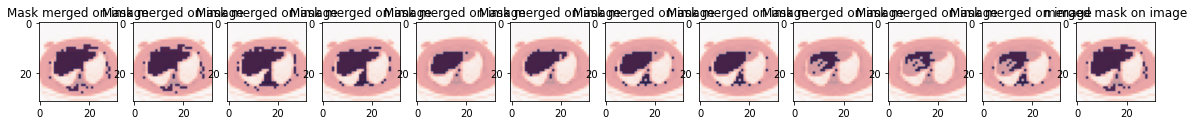

In [16]:
# plot

cluster_labels = []
for i in range(len(similarity_matrices)):
    cluster_labels.append(similarity_matrices[i][2])

h.plot_multiple_masks(masks, cluster_labels, source_image)

In [ ]:
plt.figure(figsize=(22,5))

plt.subplot(1, 2, 1)
plt.bar(similarity_matrices[:]["avg_clustering_coeff"])
plt.title('Average Clustering coefficients.')

plt.subplot(1, 2, 2)
plt.bar(similarity_matrices[:]["normalized_cut_value"])
plt.title('Normalized cut values')

plt.show()